In [1]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical


%matplotlib inline

In [2]:
                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

In [3]:
# where am i?
%pwd

'C:\\Users\\david\\Documents\\ImageNet'

In [4]:
flowers = glob.glob('./data/flr_*.jpg')
fungus = glob.glob('./data/fgs_*.jpg')
rocks = glob.glob('./data/rck_*.jpg')

pixel_flowers = glob.glob('./data/pxl_flower_*.jpeg')
pixel_umbrella = glob.glob('./data/pxl_umbrella_*.jpeg')
print("There are %s, %s flower, %s fungus, %s rock and %s umbrella pictures" %(len(flowers), len(pixel_flowers), len(fungus), len(rocks), len(pixel_umbrella)))

There are 1269, 1792 flower, 856 fungus, 1007 rock and 420 umbrella pictures


Showing: ./data\flr_01516.jpg


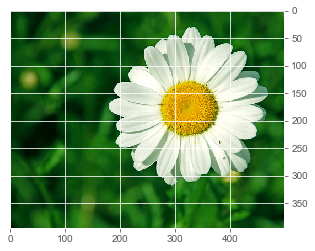

Showing: ./data\flr_01887.jpg


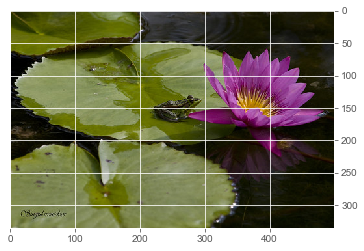

Showing: ./data\flr_01409.jpg


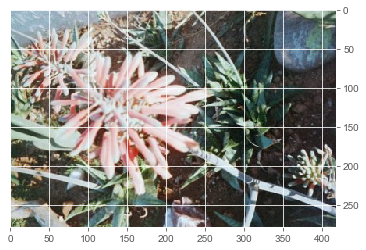

Showing: ./data\flr_01219.jpg


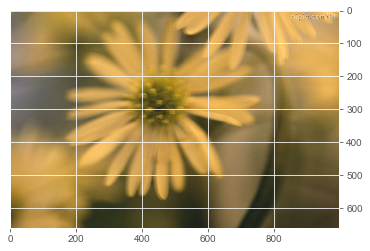

Showing: ./data\flr_01675.jpg


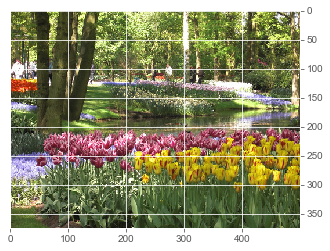

In [5]:
# Randomly show 10 examples of the images
from IPython.display import Image
    
dataset = flowers #flowers #fungus #rocks

for i in range(0, 5):
    index = random.randint(0, len(dataset)-1)   
    print("Showing:", dataset[index])
    
    img = mpimg.imread(dataset[index])
    imgplot = plt.imshow(img)
    plt.show()

#Image(dataset[index])

# Extract the training and testing datasets

In [6]:
# Load the data
trDatOrg       = np.load('flrnonflr-train-imgs96-0.8.npz')['arr_0']
trLblOrg       = np.load('flrnonflr-train-labels96-0.8.npz')['arr_0']
tsDatOrg       = np.load('flrnonflr-test-imgs96-0.8.npz')['arr_0']
tsLblOrg       = np.load('flrnonflr-test-labels96-0.8.npz')['arr_0']

In [7]:
print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (4264, 96, 96, 3), (4264,), (1067, 96, 96, 3), (1067,)


Showing 1027 index image, It is 0.0


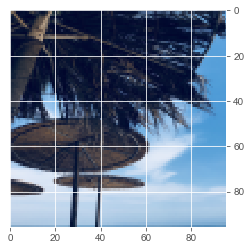

Showing 294 index image, It is 1.0


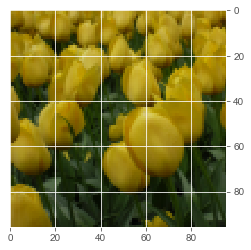

Showing 647 index image, It is 0.0


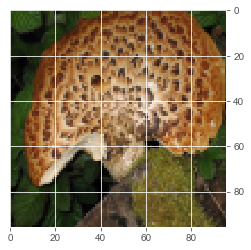

Showing 675 index image, It is 0.0


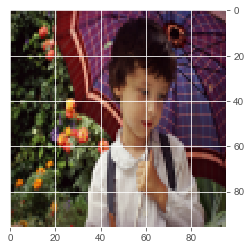

Showing 291 index image, It is 1.0


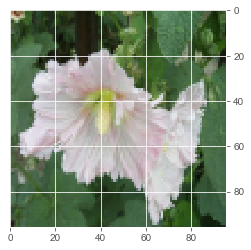

Showing 431 index image, It is 1.0


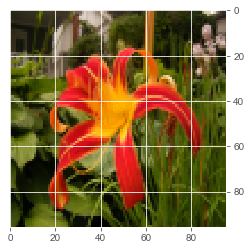

Showing 935 index image, It is 0.0


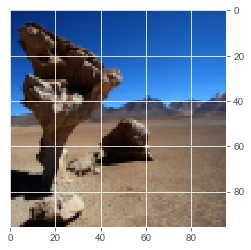

Showing 690 index image, It is 0.0


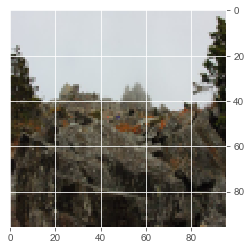

Showing 800 index image, It is 0.0


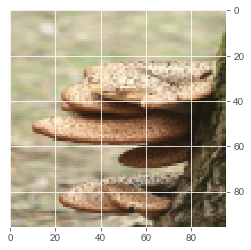

Showing 966 index image, It is 0.0


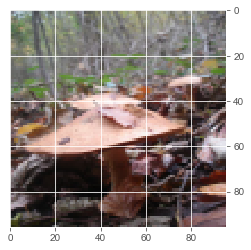

Showing 870 index image, It is 0.0


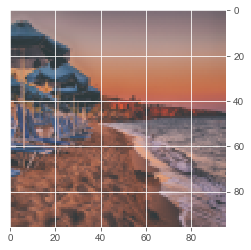

Showing 2 index image, It is 1.0


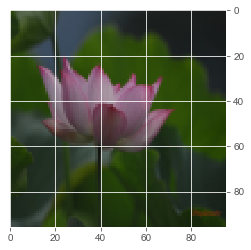

Showing 318 index image, It is 1.0


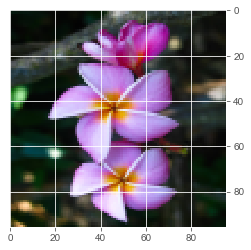

Showing 306 index image, It is 1.0


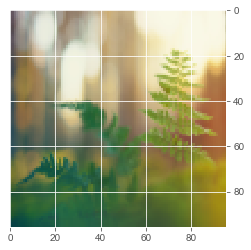

Showing 643 index image, It is 0.0


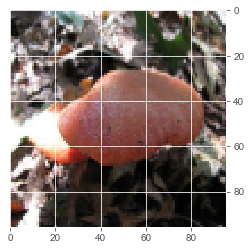

Showing 490 index image, It is 1.0


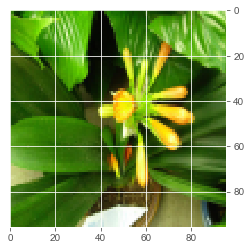

Showing 133 index image, It is 1.0


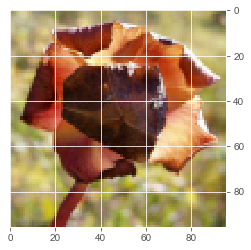

Showing 97 index image, It is 1.0


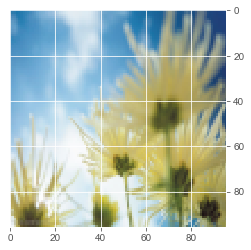

Showing 9 index image, It is 1.0


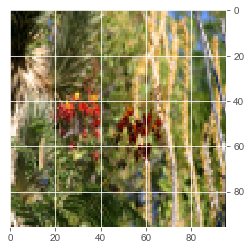

Showing 281 index image, It is 1.0


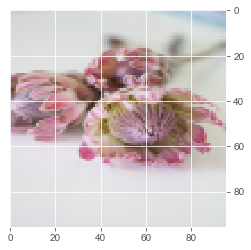

In [8]:
# Randomly show 10 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(20):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [9]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# # reshape the data to be [samples][width][height][channel]
# # This is required by Keras framework
# trDat       = trDat.reshape(trDat.shape[0], imgrows, imgclms, channel)
# tsDat       = tsDat.reshape(tsDat.shape[0], imgrows, imgclms, channel)

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

In [10]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)


modelname = 'FlowerPower'

def createBaselineModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(30, (4, 4), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(50, (4, 4), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

optmz       = optimizers.Adam(lr=0.001)

def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    convLyr = Conv2D(numFilters, kernel_size=kernelSz, strides=strides, 
                     padding='same', kernel_initializer='he_normal', 
                     kernel_regularizer=l2(1e-4), 
                     name=lyrName+'_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName+'_'+activation if lyrName else None)(x)
        x = convLyr(x)
    return x


def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    x = inputs
    for run in range(0,numBlocks):
        strides = 1
        blkStr = str(run+1)
        if downsampleOnFirst and run == 0:
            strides = 2
        y = resLyr(inputs=x, numFilters=numFilters, strides=strides,
                   lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y, numFilters=numFilters, activation=None,
                   lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x, numFilters=numFilters, kernelSz=1,
                       strides=strides, activation=None, batchNorm=False,
                       lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
        x = add([x,y], name=names+'_Blk'+blkStr+'_add' if names else None)
        x = Activation('relu', name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
    return x

def createResNetV1(inputShape=(imgrows, imgclms, channel),
                   numClasses=2):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(inputs=v, numFilters=16, numBlocks=3,
                 downsampleOnFirst=False, names='Stg1')
    v = resBlkV1(inputs=v, numFilters=32, numBlocks=3,
                 downsampleOnFirst=True, names='Stg2')
    v = resBlkV1(inputs=v, numFilters=64, numBlocks=3,
                 downsampleOnFirst=True, names='Stg3')
    v = AveragePooling2D(pool_size=8, name='AvgPool')(v)
    v = Flatten()(v) 
    outputs = Dense(numClasses, activation='softmax', 
                    kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optmz, 
                  metrics=['accuracy'])
    return model



# Setup the models
model       = createBaselineModel() # This is meant for training
modelGo     = createBaselineModel() # This is used for final testing

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 93, 93, 30)        1470      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 43, 50)        24050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 22050)             0         
__________

In [11]:
# Create checkpoint for the training
# This checkpoint performs model saving when
# an epoch gives highest testing accuracy
# filepath        = modelname + ".hdf5"
# checkpoint      = ModelCheckpoint(filepath, 
#                                   monitor='val_acc', 
#                                   verbose=0, 
#                                   save_best_only=True, 
#                                   mode='max')

#                             # Log the epoch detail into csv
# csv_logger      = CSVLogger(modelname +'.csv')
# callbacks_list  = [checkpoint,csv_logger]

def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 70:
        lr  *= 0.5e-3
        
    elif epoch > 50:
        lr  *= 1e-3
        
    elif epoch > 40:
        lr  *= 1e-2
        
    elif epoch > 30:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
#callbacks_list  = [checkpoint, csv_logger, LRScheduler]
callbacks_list  = [checkpoint, csv_logger]

In [12]:
# Fit the model
# This is where the training starts
model.fit(trDat, 
          trLbl, 
          validation_data=(tsDat, tsLbl), 
          epochs=120, 
          batch_size=32,
          callbacks=callbacks_list)

# datagen = ImageDataGenerator(width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              rotation_range=30,
#                              horizontal_flip=True,
#                              vertical_flip=False)

# model.fit_generator(datagen.flow(trDat, trLbl, batch_size=64),
#                     validation_data=(tsDat, tsLbl),
#                     epochs=120, 
#                     verbose=1,
#                     steps_per_epoch=len(trDat)/64,
#                     callbacks=callbacks_list)

Train on 4264 samples, validate on 1067 samples
Epoch 1/120
4264/4264 [==============================] - 22s 5ms/step - loss: 0.5435 - acc: 0.7221 - val_loss: 0.4894 - val_acc: 0.7582
Epoch 2/120
4264/4264 [==============================] - 4s 874us/step - loss: 0.4403 - acc: 0.8009 - val_loss: 0.3926 - val_acc: 0.8332
Epoch 3/120
4264/4264 [==============================] - 4s 875us/step - loss: 0.3774 - acc: 0.8326 - val_loss: 0.3421 - val_acc: 0.8688
Epoch 4/120
4264/4264 [==============================] - 4s 882us/step - loss: 0.3495 - acc: 0.8480 - val_loss: 0.3679 - val_acc: 0.8472
Epoch 5/120
4264/4264 [==============================] - 4s 955us/step - loss: 0.2939 - acc: 0.8783 - val_loss: 0.3498 - val_acc: 0.8529
Epoch 6/120
4264/4264 [==============================] - 4s 1ms/step - loss: 0.2613 - acc: 0.8940 - val_loss: 0.3786 - val_acc: 0.8472
Epoch 7/120
4264/4264 [==============================] - 4s 931us/step - loss: 0.2322 - acc: 0.9048 - val_loss: 0.4001 - val_acc: 0.8

4264/4264 [==============================] - 5s 1ms/step - loss: 0.0078 - acc: 0.9977 - val_loss: 1.0680 - val_acc: 0.8472
Epoch 61/120
4264/4264 [==============================] - 4s 974us/step - loss: 0.0075 - acc: 0.9977 - val_loss: 1.1448 - val_acc: 0.8557
Epoch 62/120
4264/4264 [==============================] - 4s 1ms/step - loss: 0.0421 - acc: 0.9866 - val_loss: 1.0927 - val_acc: 0.8341
Epoch 63/120
4264/4264 [==============================] - 4s 1ms/step - loss: 0.0227 - acc: 0.9923 - val_loss: 0.9728 - val_acc: 0.8379
Epoch 64/120
4264/4264 [==============================] - 4s 938us/step - loss: 0.0220 - acc: 0.9937 - val_loss: 0.9391 - val_acc: 0.8416
Epoch 65/120
4264/4264 [==============================] - 4s 978us/step - loss: 0.0104 - acc: 0.9967 - val_loss: 0.8992 - val_acc: 0.8538
Epoch 66/120
4264/4264 [==============================] - 5s 1ms/step - loss: 0.0113 - acc: 0.9965 - val_loss: 0.9591 - val_acc: 0.8463
Epoch 67/120
4264/4264 [==============================]

4264/4264 [==============================] - 4s 881us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 1.0697 - val_acc: 0.8454
Epoch 120/120
4264/4264 [==============================] - 4s 1ms/step - loss: 6.6477e-04 - acc: 0.9998 - val_loss: 1.2111 - val_acc: 0.8519


In [13]:
## Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [14]:
# Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['flower', 'non-flower']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 87.25%
              precision    recall  f1-score   support

      flower     0.8581    0.8392    0.8486       454
  non-flower     0.8828    0.8972    0.8900       613

    accuracy                         0.8725      1067
   macro avg     0.8705    0.8682    0.8693      1067
weighted avg     0.8723    0.8725    0.8723      1067

[[381  73]
 [ 63 550]]


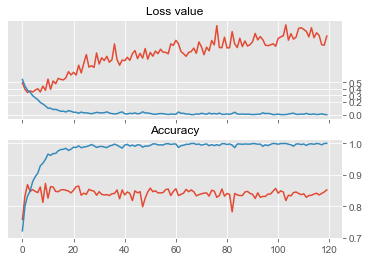

In [15]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.30, 0.4, 0.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

In [16]:
wrong_ans_index = []

for i in range(len(predout)):
    if predout[i] != testout[i]:
        wrong_ans_index.append(i)

In [17]:
wrong_ans_index = list(set(wrong_ans_index))

Showing 512 index image
Predicted as 0 but is actually 1


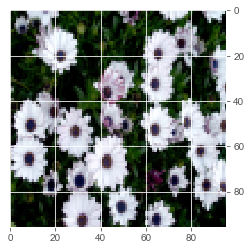

Showing 3 index image
Predicted as 0 but is actually 1


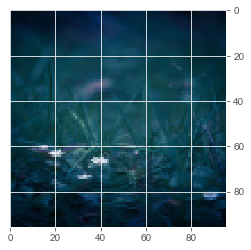

Showing 515 index image
Predicted as 0 but is actually 1


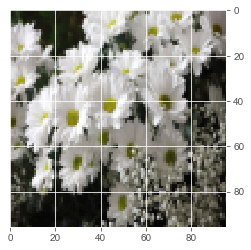

Showing 1031 index image
Predicted as 1 but is actually 0


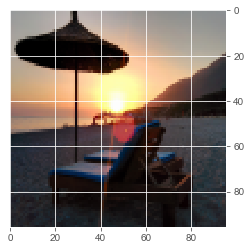

Showing 12 index image
Predicted as 0 but is actually 1


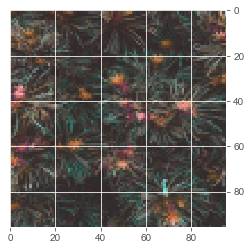

Showing 1038 index image
Predicted as 1 but is actually 0


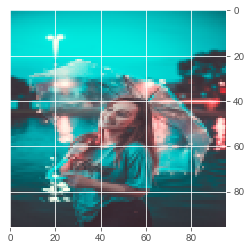

Showing 1039 index image
Predicted as 1 but is actually 0


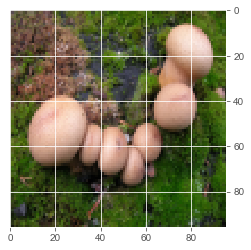

Showing 1040 index image
Predicted as 1 but is actually 0


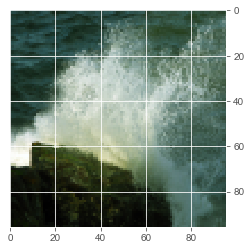

Showing 1045 index image
Predicted as 1 but is actually 0


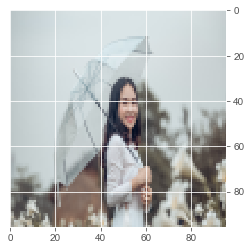

Showing 539 index image
Predicted as 0 but is actually 1


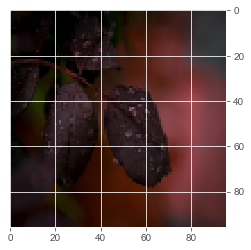

Showing 1023 index image
Predicted as 1 but is actually 0


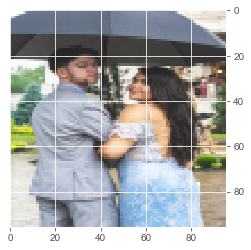

Showing 29 index image
Predicted as 0 but is actually 1


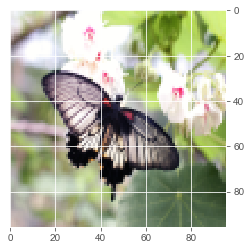

Showing 544 index image
Predicted as 0 but is actually 1


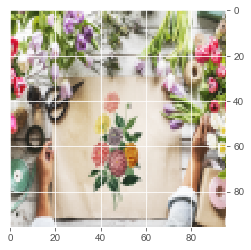

Showing 1056 index image
Predicted as 1 but is actually 0


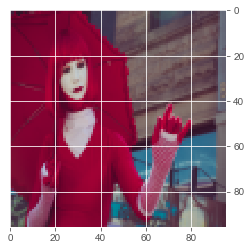

Showing 568 index image
Predicted as 0 but is actually 1


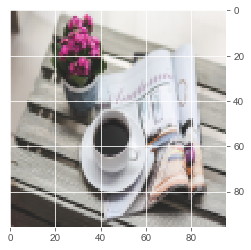

Showing 65 index image
Predicted as 0 but is actually 1


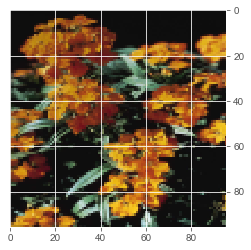

Showing 72 index image
Predicted as 0 but is actually 1


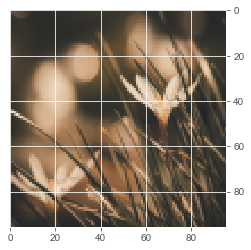

Showing 594 index image
Predicted as 0 but is actually 1


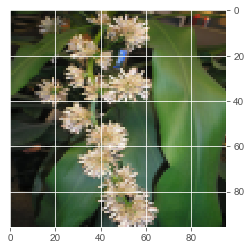

Showing 596 index image
Predicted as 0 but is actually 1


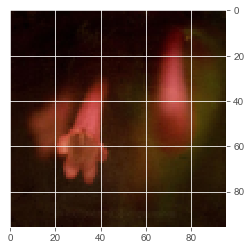

Showing 92 index image
Predicted as 0 but is actually 1


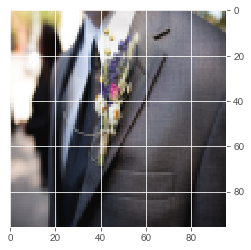

Showing 613 index image
Predicted as 1 but is actually 0


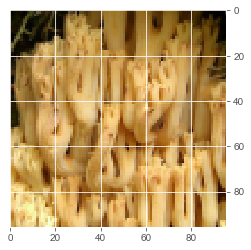

Showing 615 index image
Predicted as 1 but is actually 0


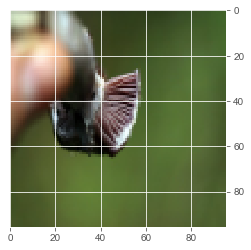

Showing 616 index image
Predicted as 1 but is actually 0


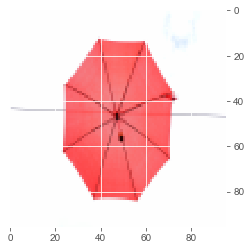

Showing 617 index image
Predicted as 1 but is actually 0


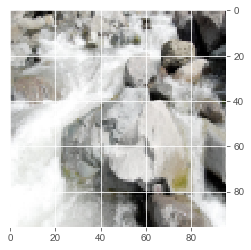

Showing 622 index image
Predicted as 1 but is actually 0


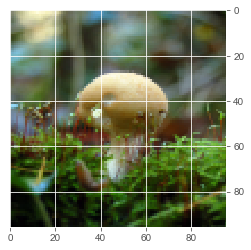

Showing 111 index image
Predicted as 0 but is actually 1


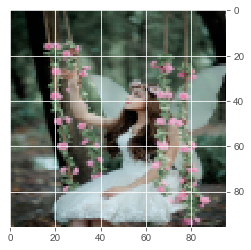

Showing 632 index image
Predicted as 1 but is actually 0


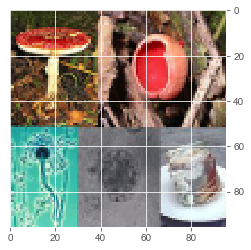

Showing 633 index image
Predicted as 1 but is actually 0


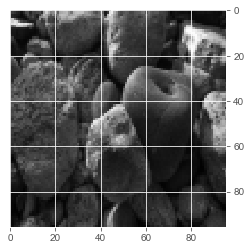

Showing 120 index image
Predicted as 0 but is actually 1


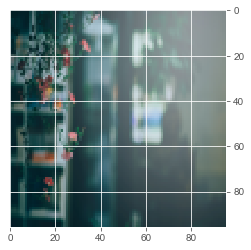

Showing 129 index image
Predicted as 0 but is actually 1


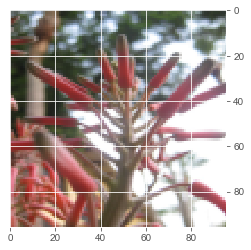

Showing 131 index image
Predicted as 0 but is actually 1


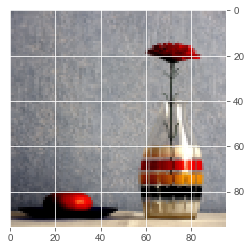

Showing 133 index image
Predicted as 0 but is actually 1


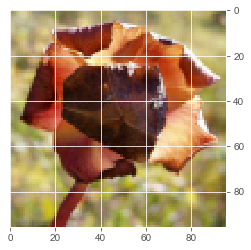

Showing 645 index image
Predicted as 1 but is actually 0


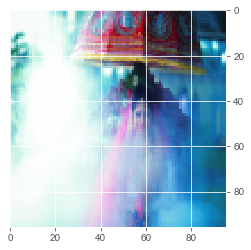

Showing 137 index image
Predicted as 0 but is actually 1


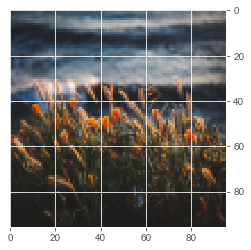

Showing 138 index image
Predicted as 0 but is actually 1


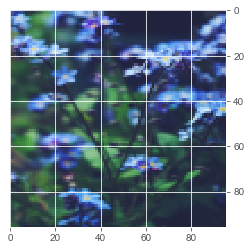

Showing 148 index image
Predicted as 0 but is actually 1


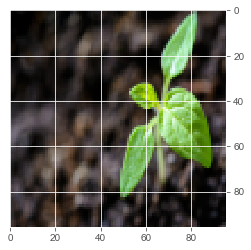

Showing 662 index image
Predicted as 1 but is actually 0


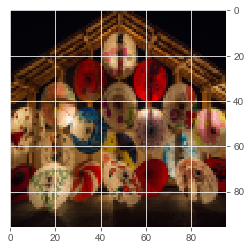

Showing 156 index image
Predicted as 0 but is actually 1


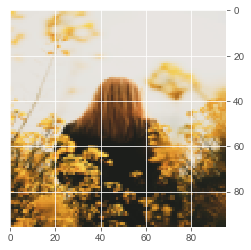

Showing 157 index image
Predicted as 0 but is actually 1


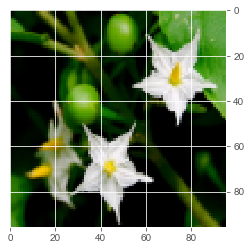

Showing 668 index image
Predicted as 1 but is actually 0


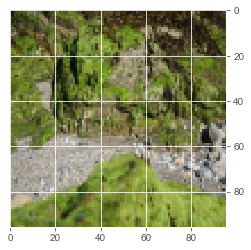

Showing 163 index image
Predicted as 0 but is actually 1


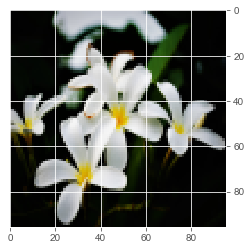

Showing 164 index image
Predicted as 0 but is actually 1


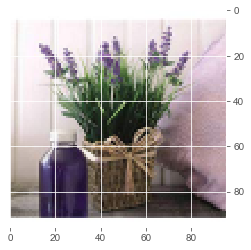

Showing 675 index image
Predicted as 1 but is actually 0


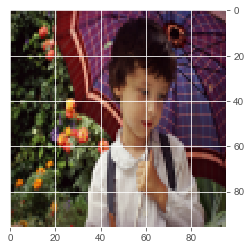

Showing 677 index image
Predicted as 1 but is actually 0


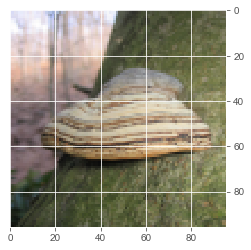

Showing 169 index image
Predicted as 0 but is actually 1


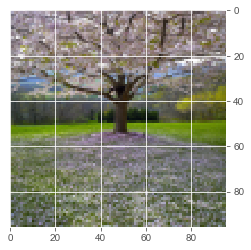

Showing 170 index image
Predicted as 0 but is actually 1


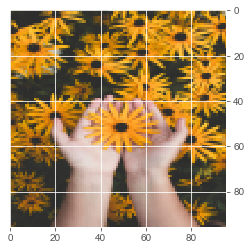

Showing 172 index image
Predicted as 0 but is actually 1


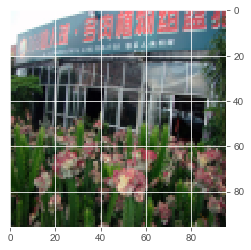

Showing 176 index image
Predicted as 0 but is actually 1


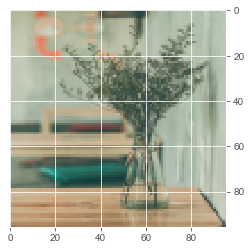

Showing 184 index image
Predicted as 0 but is actually 1


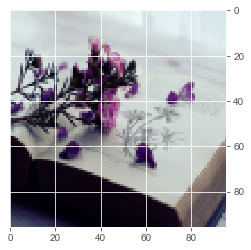

Showing 188 index image
Predicted as 0 but is actually 1


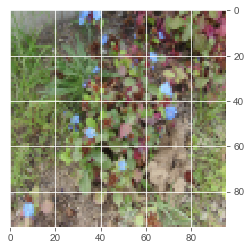

Showing 189 index image
Predicted as 0 but is actually 1


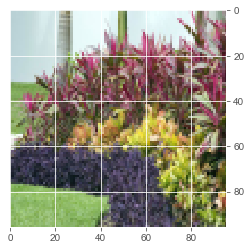

Showing 707 index image
Predicted as 1 but is actually 0


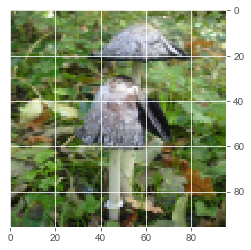

Showing 718 index image
Predicted as 1 but is actually 0


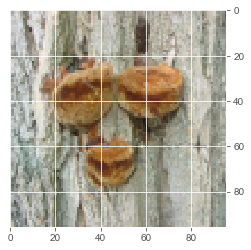

Showing 208 index image
Predicted as 0 but is actually 1


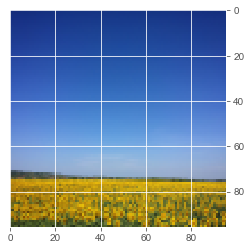

Showing 720 index image
Predicted as 1 but is actually 0


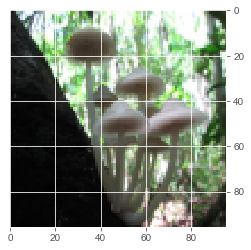

Showing 219 index image
Predicted as 0 but is actually 1


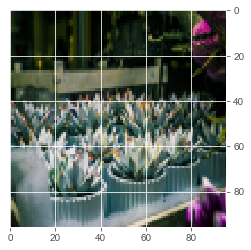

Showing 732 index image
Predicted as 1 but is actually 0


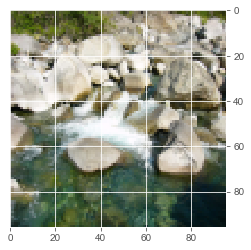

Showing 733 index image
Predicted as 1 but is actually 0


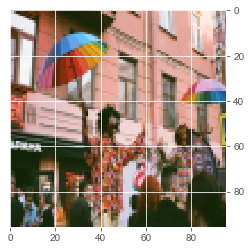

Showing 228 index image
Predicted as 0 but is actually 1


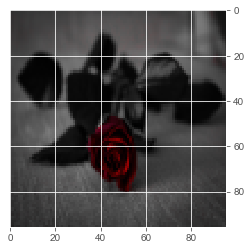

Showing 740 index image
Predicted as 1 but is actually 0


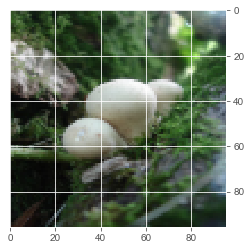

Showing 743 index image
Predicted as 1 but is actually 0


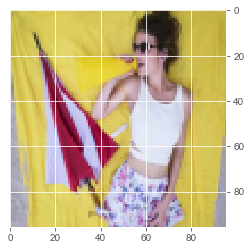

Showing 745 index image
Predicted as 1 but is actually 0


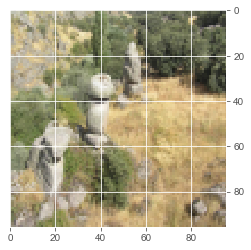

Showing 749 index image
Predicted as 1 but is actually 0


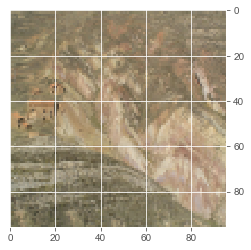

Showing 757 index image
Predicted as 1 but is actually 0


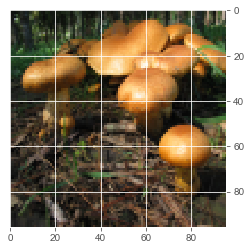

Showing 247 index image
Predicted as 0 but is actually 1


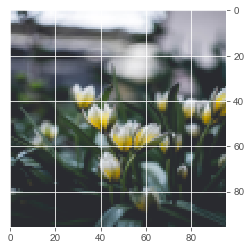

Showing 759 index image
Predicted as 1 but is actually 0


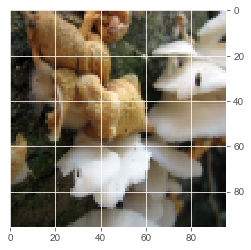

Showing 253 index image
Predicted as 0 but is actually 1


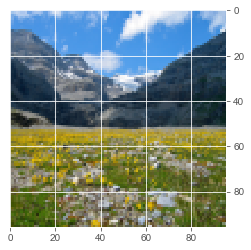

Showing 765 index image
Predicted as 1 but is actually 0


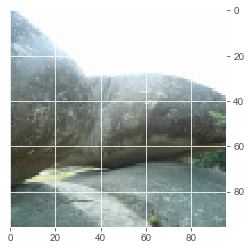

Showing 766 index image
Predicted as 1 but is actually 0


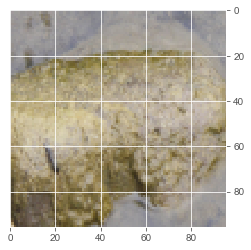

Showing 768 index image
Predicted as 1 but is actually 0


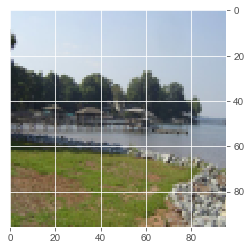

Showing 258 index image
Predicted as 0 but is actually 1


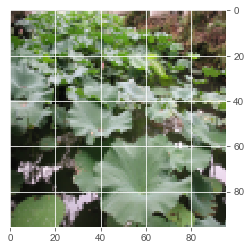

Showing 261 index image
Predicted as 0 but is actually 1


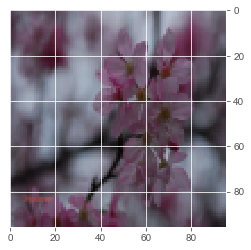

Showing 774 index image
Predicted as 1 but is actually 0


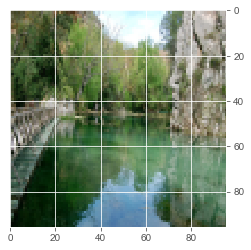

Showing 775 index image
Predicted as 1 but is actually 0


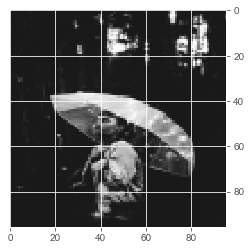

Showing 778 index image
Predicted as 1 but is actually 0


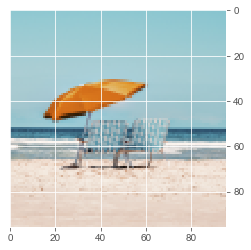

Showing 789 index image
Predicted as 1 but is actually 0


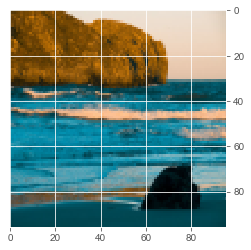

Showing 790 index image
Predicted as 1 but is actually 0


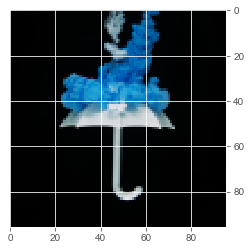

Showing 279 index image
Predicted as 0 but is actually 1


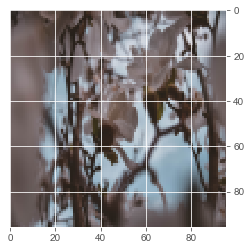

Showing 791 index image
Predicted as 1 but is actually 0


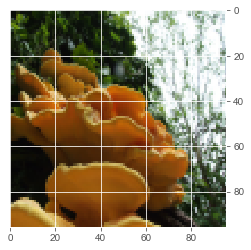

Showing 792 index image
Predicted as 1 but is actually 0


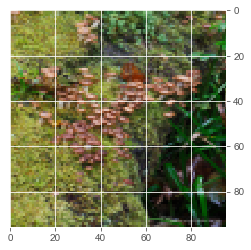

Showing 794 index image
Predicted as 1 but is actually 0


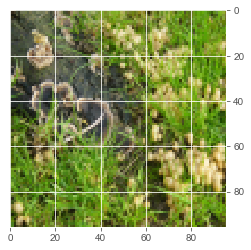

Showing 796 index image
Predicted as 1 but is actually 0


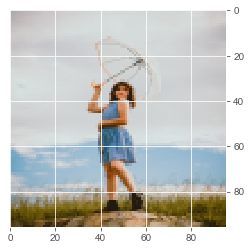

Showing 798 index image
Predicted as 1 but is actually 0


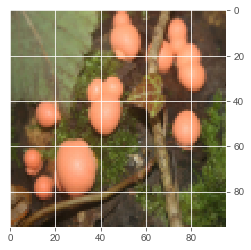

Showing 288 index image
Predicted as 0 but is actually 1


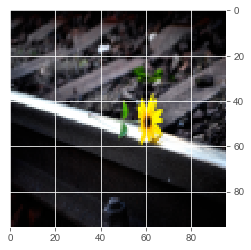

Showing 801 index image
Predicted as 1 but is actually 0


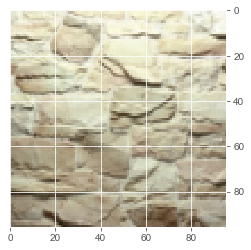

Showing 805 index image
Predicted as 1 but is actually 0


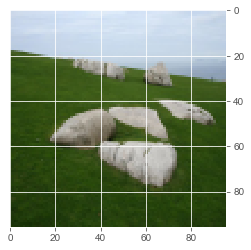

Showing 808 index image
Predicted as 1 but is actually 0


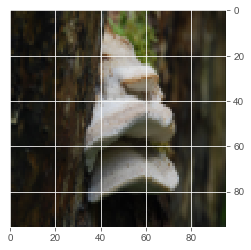

Showing 830 index image
Predicted as 1 but is actually 0


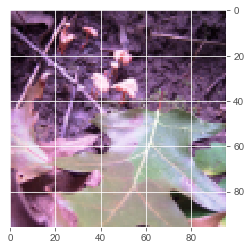

Showing 834 index image
Predicted as 1 but is actually 0


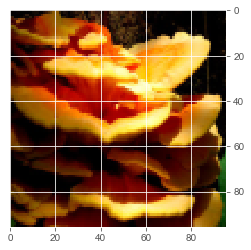

Showing 840 index image
Predicted as 1 but is actually 0


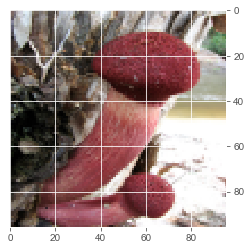

Showing 329 index image
Predicted as 0 but is actually 1


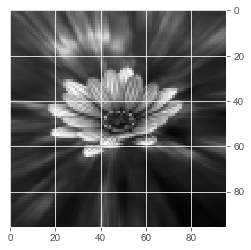

Showing 841 index image
Predicted as 1 but is actually 0


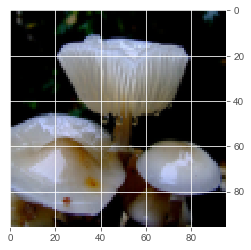

Showing 331 index image
Predicted as 0 but is actually 1


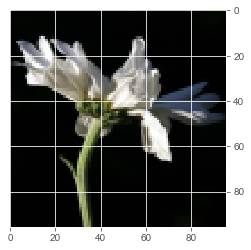

Showing 843 index image
Predicted as 1 but is actually 0


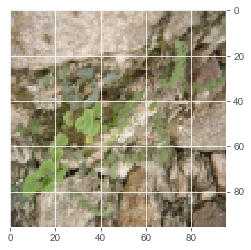

Showing 844 index image
Predicted as 1 but is actually 0


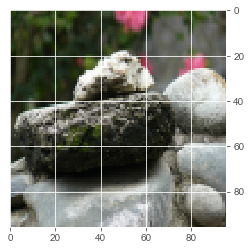

Showing 845 index image
Predicted as 1 but is actually 0


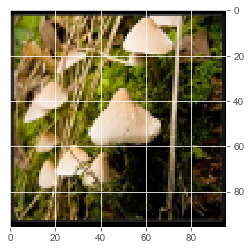

Showing 336 index image
Predicted as 0 but is actually 1


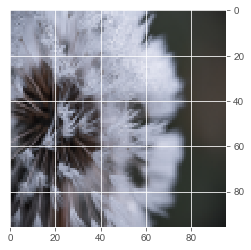

Showing 848 index image
Predicted as 1 but is actually 0


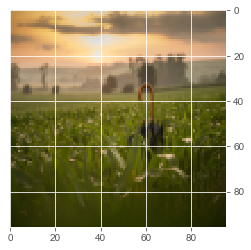

Showing 349 index image
Predicted as 0 but is actually 1


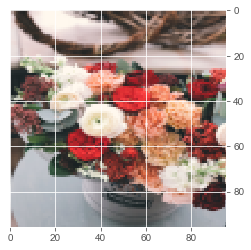

Showing 864 index image
Predicted as 1 but is actually 0


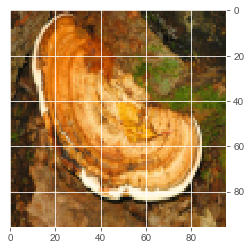

Showing 355 index image
Predicted as 0 but is actually 1


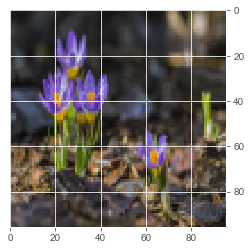

Showing 867 index image
Predicted as 1 but is actually 0


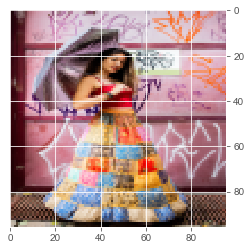

Showing 365 index image
Predicted as 0 but is actually 1


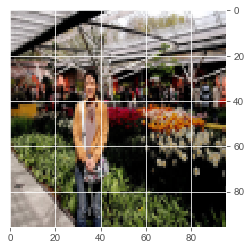

Showing 366 index image
Predicted as 0 but is actually 1


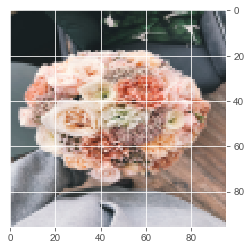

Showing 877 index image
Predicted as 1 but is actually 0


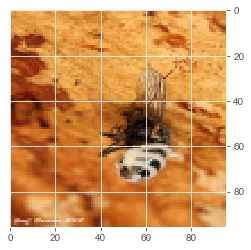

Showing 878 index image
Predicted as 1 but is actually 0


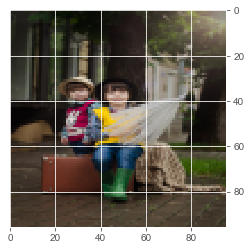

Showing 880 index image
Predicted as 1 but is actually 0


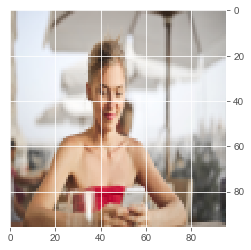

Showing 371 index image
Predicted as 0 but is actually 1


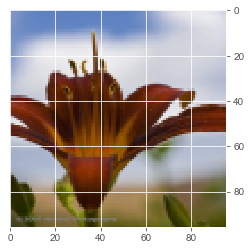

Showing 889 index image
Predicted as 1 but is actually 0


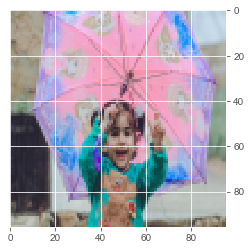

Showing 382 index image
Predicted as 0 but is actually 1


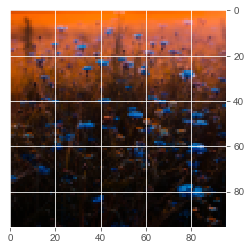

Showing 894 index image
Predicted as 1 but is actually 0


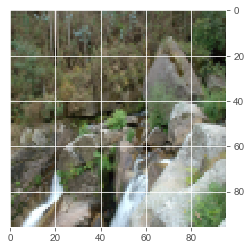

Showing 391 index image
Predicted as 0 but is actually 1


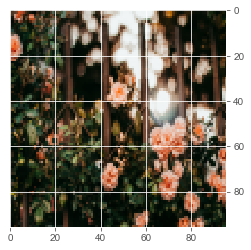

Showing 904 index image
Predicted as 1 but is actually 0


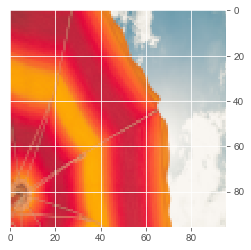

Showing 402 index image
Predicted as 0 but is actually 1


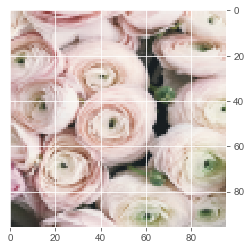

Showing 418 index image
Predicted as 0 but is actually 1


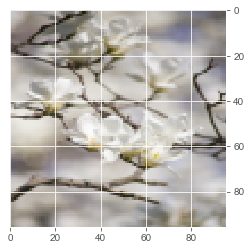

Showing 420 index image
Predicted as 0 but is actually 1


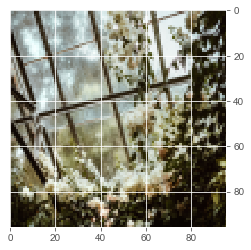

Showing 427 index image
Predicted as 0 but is actually 1


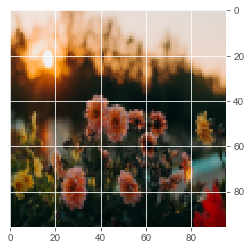

Showing 942 index image
Predicted as 1 but is actually 0


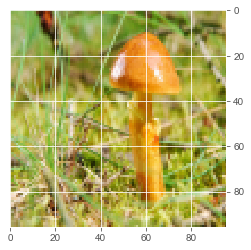

Showing 958 index image
Predicted as 1 but is actually 0


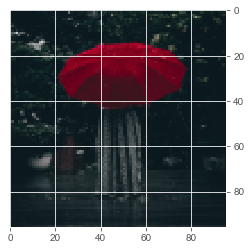

Showing 961 index image
Predicted as 1 but is actually 0


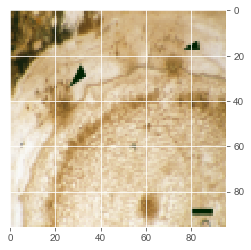

Showing 454 index image
Predicted as 0 but is actually 1


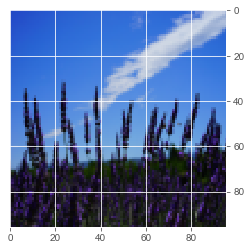

Showing 974 index image
Predicted as 1 but is actually 0


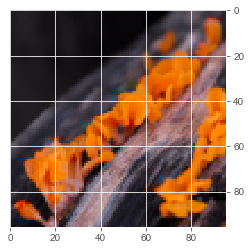

Showing 975 index image
Predicted as 1 but is actually 0


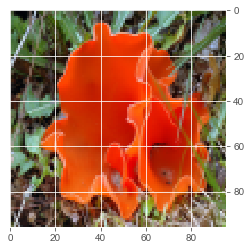

Showing 468 index image
Predicted as 0 but is actually 1


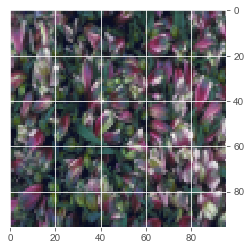

Showing 982 index image
Predicted as 1 but is actually 0


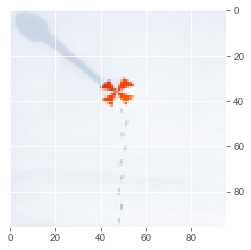

Showing 471 index image
Predicted as 0 but is actually 1


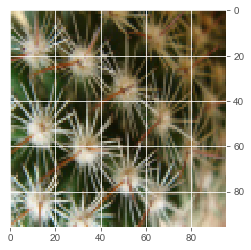

Showing 474 index image
Predicted as 0 but is actually 1


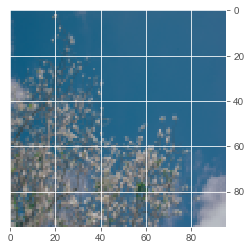

Showing 491 index image
Predicted as 0 but is actually 1


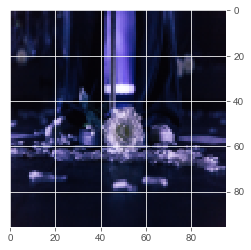

Showing 1005 index image
Predicted as 1 but is actually 0


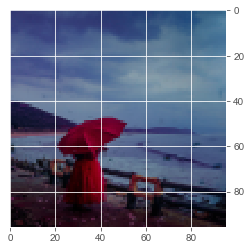

Showing 1007 index image
Predicted as 1 but is actually 0


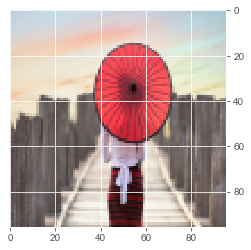

Showing 498 index image
Predicted as 0 but is actually 1


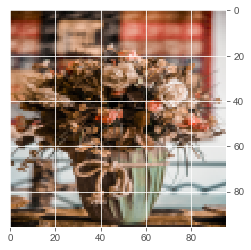

Showing 1015 index image
Predicted as 1 but is actually 0


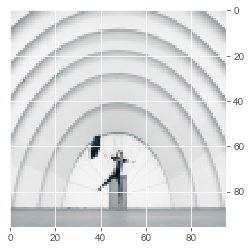

Showing 505 index image
Predicted as 0 but is actually 1


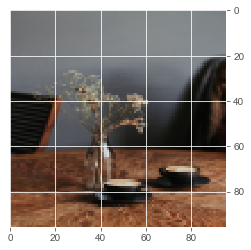

Showing 1019 index image
Predicted as 1 but is actually 0


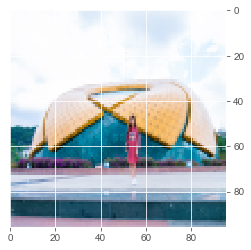

Showing 1022 index image
Predicted as 1 but is actually 0


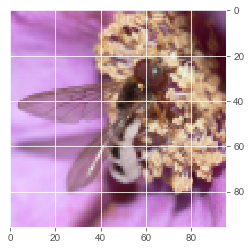

Showing 511 index image
Predicted as 0 but is actually 1


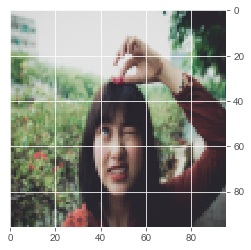

In [18]:
# Randomly show X examples of that was wrong

dataset = tsDatOrg #flowers #fungus #rocks

for index in wrong_ans_index:
    #index = wrong_ans_index[random.randint(0, len(wrong_ans_index)-1)]
    print("Showing %s index image" %(index))
    print("Predicted as %s but is actually %s" %(predout[index], testout[index]))
    imgplot = plt.imshow(data[index])
    plt.show()